
# LangGraph Reflection 机制开发指南

本指南详细介绍了如何在 **LangGraph** 中构建基于大语言模型（LLM）的 **Reflection（反思）** 机制。

Reflection 是一种重要的模型能力，通过让模型观察其过去的步骤和外部环境反馈，评估自身行为的质量，并不断改进输出。在生成与反思的循环中，模型可以逐步优化内容，从而提升生成质量和用户满意度。

Reflection 机制被广泛应用于生成任务中，例如文章写作、内容修改与反馈、以及智能助理等场景。通过引导 LLM 进行自我反思和用户反馈处理，开发者可以让模型在多轮交互中自动调整其生成的内容，达到高效、精准、结构完善的输出。



在本指南中，我们会逐步演示如何搭建这一机制，包括从基础的环境配置到生成器和反思器的构建，再到如何使用 LangGraph 状态图实现生成-反思循环的完整流程。无论您是为文章生成、内容评估，还是其他复杂任务设计 LLM 代理，本指南都将为您提供详细的开发思路和实用的代码示例。

![reflection](./images/reflection.png)

通过本指南，您将学习如何：
1. 设置开发环境并安装所需包；
2. 定义和生成灵活结构的文章，不局限于传统的五段式；
3. 通过反思机制批改生成内容，并提供详细反馈；
4. 构建反思与生成的状态循环，使模型持续改进生成内容。

本开发指南适合任何希望构建复杂 LLM 任务的开发者，特别是需要实现生成-反思流程、文章批改反馈、或其他高级交互任务的场景。


## 1. 环境设置
首先，安装所需的包并设置API密钥：

In [1]:
%%capture --no-stderr
%pip install langchain langgraph langchain-ollama tavily-python

In [2]:
import getpass
import os

# 定义一个帮助函数来检查环境变量，如果不存在则提示用户输入
def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"请输入您的 {var}")

# 设置 OpenAI 和 Langchain API 密钥
# _set_if_undefined("OPENAI_API_KEY")
# _set_if_undefined("LANGCHAIN_API_KEY")
# _set_if_undefined("TAVILY_API_KEY")


## 2. LangSmith开发配置
LangSmith能够帮助您快速发现问题并提高LangGraph项目的性能。通过LangSmith，您可以使用跟踪数据来调试、测试和监控基于LangGraph构建的LLM应用程序。

In [3]:
# 在 LangSmith 中添加追踪功能
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Reflection"

## 3. 定义写作助手智能体

我们定义的这个助手是一个写作助手，旨在为用户生成高质量、结构清晰且引人入胜的文章。它的任务是根据用户的请求撰写内容，无论是短文、长篇、议论文还是其他类型的文章，都能够灵活应对。助手会专注于文章的清晰度、结构和质量，确保输出的内容是精心打磨过的。如果用户对生成的内容有反馈或建议，助手还能够根据这些反馈改进和优化文章，使其更符合用户的期望。这种互动机制保证了写作过程的灵活性和个性化，从而让用户获得更符合需求的成品。


### System Prompt 详细解释：
1. **"You are a writing assistant"**：写作助手的角色设定，让模型明确其任务是帮助用户进行写作。
   
2. **"well-crafted, coherent, and engaging articles"**：描述了文章应该具备的特性，包括“精心撰写的、连贯的和吸引人的”，但没有限制文章的具体结构，可以是不同类型的文章（如叙述文、议论文等）。

3. **"Focus on clarity, structure, and quality"**：明确了撰写时需要关注的核心要素：清晰度、结构性和质量，确保输出内容优秀。

4. **"revise and improve the writing"**：模型可以根据用户的反馈进行修改和优化，保持互动的灵活性。


In [1]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from langchain_ollama.chat_models import ChatOllama

writer_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a writing assistant tasked with creating well-crafted, coherent, and engaging articles based on the user's request."
            " Focus on clarity, structure, and quality to produce the best possible piece of writing."
            " If the user provides feedback or suggestions, revise and improve the writing to better align with their expectations.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# writer = ChatOpenAI(model="gpt-4o-mini")

In [2]:
writer = writer_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=1.2,
)

In [4]:
article = ""

topic = HumanMessage(
    content="参考鲁迅的风格，改写吴承恩的西游记中任意篇章"
)

for chunk in writer.stream({"messages": [topic]}):
    print(chunk.content, end="")
    article += chunk.content

题目：《蟒神潇洒》

本次改写的篇章为《西游记》中第六回“唐僧被绑出华阳关, 逃脱后又被金蝉子绑住”。鲁迅式的风格通常以幽默、讥诮和尖锐的语言著称，下面是改写后的篇章：

---

我不曾知道，一只蟒神居然可以有那么多姿势。

金蟒出自大海深处，是个无厘头的家伙，喜欢在华山麓游来玩去。听说他擅长打扮成各种各样的装束，令众人看了莫名其妙。

那日，唐僧一行人刚到达华阳关边上，大口大口地吞下蟒神变出的两块大饼。大碗呃得呼呼响的唐僧，更显得跟那座山一样胖。

金蝉子是个能打擂鼓、跳芭蕾舞、背刺客手法书的人物。他想趁机杀死唐僧，自己做佛教圣人。于是一招手，让一只大蚊子把蟒神的头绑住了。

忽然，金蝉又变了一回生，这回他是大虫子模样了。一溜烟地跑得无影无踪。

蟒神头上一块绳子还未解开，他就跳下华阳关，没入滔滔黄河中去。他随身带着唐僧，一直到了长江边。金蝉只说“走，去那边吃些青苇吧”便逃窜了。

蟒神突然停住，并且睁眼朝唐僧笑着道：“你看我有多么潇洒？”这只蟒神，确实有些了不起。

In [5]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(article))

题目：《蟒神潇洒》

本次改写的篇章为《西游记》中第六回“唐僧被绑出华阳关, 逃脱后又被金蝉子绑住”。鲁迅式的风格通常以幽默、讥诮和尖锐的语言著称，下面是改写后的篇章：

---

我不曾知道，一只蟒神居然可以有那么多姿势。

金蟒出自大海深处，是个无厘头的家伙，喜欢在华山麓游来玩去。听说他擅长打扮成各种各样的装束，令众人看了莫名其妙。

那日，唐僧一行人刚到达华阳关边上，大口大口地吞下蟒神变出的两块大饼。大碗呃得呼呼响的唐僧，更显得跟那座山一样胖。

金蝉子是个能打擂鼓、跳芭蕾舞、背刺客手法书的人物。他想趁机杀死唐僧，自己做佛教圣人。于是一招手，让一只大蚊子把蟒神的头绑住了。

忽然，金蝉又变了一回生，这回他是大虫子模样了。一溜烟地跑得无影无踪。

蟒神头上一块绳子还未解开，他就跳下华阳关，没入滔滔黄河中去。他随身带着唐僧，一直到了长江边。金蝉只说“走，去那边吃些青苇吧”便逃窜了。

蟒神突然停住，并且睁眼朝唐僧笑着道：“你看我有多么潇洒？”这只蟒神，确实有些了不起。

----------
## 4. 定义审阅老师智能体

下面我们使用反思机制批改生成的作文，生成一篇作文的反馈和建议。

模型扮演“老师”角色，针对用户提交的作文进行打分、批改和提供改进建议。

### System Prompt 详细解释：

- **"You are a teacher grading an essay submission."**
  - 模型被设定为一个老师角色，专门负责为用户提交的作文进行批改。这一角色定位帮助模型理解其任务是提供具有建设性的反馈和评价。
  
- **"Generate critique and recommendations for the user's submission."**
  - 模型需要生成作文的批评与建议。它不只是评估作文的好坏，还需要指出需要改进的地方，并提出具体的建议。

- **"Provide detailed recommendations, including requests for length, depth, style, etc."**
  - 这一部分进一步明确了反馈的细节，要求模型给出细致的建议。这包括：
    - **Length（长度）**：文章的字数是否合适，是否需要扩展或删减。
    - **Depth（深度）**：是否需要更深入的分析或讨论。
    - **Style（风格）**：文章的写作风格是否合适，是否符合目标读者或主题的需求。
  
这一设定确保了模型不仅给出基本反馈，还可以根据文章的具体问题提出具体的改进意见，帮助用户更好地提升其写作。

In [6]:
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a teacher grading an article submission. writer critique and recommendations for the user's submission."
            " Provide detailed recommendations, including requests for length, depth, style, etc.",

        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

reflect = reflection_prompt | ChatOllama(
    model="llama3.1:8b-instruct-q8_0",
    max_tokens=8192,
    temperature=0.2,
)

In [7]:
reflection = ""

# 将主题（topic）和生成的文章（article）作为输入发送给反思智能体
for chunk in reflect.stream({"messages": [topic, HumanMessage(content=article)]}):
    print(chunk.content, end="")
    reflection += chunk.content

很好！你的改写作品《蟒神潇洒》展现出鲁迅式的幽默和讥诮风格。以下是我的反馈和建议：

**强点：**

1. 你成功地捕捉到了鲁迅的幽默和讥诮风格，特别是在对金蝉子和蟒神的描写中。
2. 你使用了生动的语言和形象，比如“无厘头的家伙”、“莫名其妙”、“大碗呃得呼呼响”等，这使读者能够更好地想象场景。
3. 你在故事中加入了许多有趣的细节，例如蟒神的多种姿势和金蝉子的变形能力。

**弱点：**

1. **篇章长度**: 你的改写作品略短于原版第六回的内容。考虑到鲁迅的风格通常较长篇幅，你可以尝试增加一些细节或场景来丰富故事。
2. **深度和层次感**: 虽然你成功地捕捉到了幽默和讥诮，但有些地方可能需要更多的深度和层次感。例如，金蝉子的动机和心理活动可以更详细地描述，以使读者更好地理解他的行为。
3. **语言风格**: 虽然你使用了生动的语言，但在某些地方可能需要更加精确和准确的表达。例如，“莫名其妙”这个词可能不太适合鲁迅式的幽默风格，你可以尝试用更有创意的语言来描述金蝉子的行为。
4. **结尾**: 你的改写作品在结尾处略显突然，蟒神的潇洒表现似乎没有得到充分的体现。你可以考虑增加一些细节或场景来使读者更好地理解蟒神的潇洒之处。

**建议：**

1. **增加篇章长度**: 尝试增加一些细节或场景来丰富故事，例如金蝉子的动机和心理活动、蟒神的多种姿势等。
2. **深化人物性格**: 尽管你成功地捕捉到了幽默和讥诮，但有些地方可能需要更多的深度和层次感。例如，金蝉子的动机和心理活动可以更详细地描述，以使读者更好地理解他的行为。
3. **语言风格**: 尝试使用更加精确和准确的表达来描述金蝉子的行为和蟒神的多种姿势。
4. **结尾**: 考虑增加一些细节或场景来使读者更好地理解蟒神的潇洒之处。

总体来说，你的改写作品展现出鲁迅式的幽默和讥诮风格，值得继续努力！

In [8]:
from IPython.display import Markdown, display

# 使用Markdown显示优化后的格式
display(Markdown(reflection))

很好！你的改写作品《蟒神潇洒》展现出鲁迅式的幽默和讥诮风格。以下是我的反馈和建议：

**强点：**

1. 你成功地捕捉到了鲁迅的幽默和讥诮风格，特别是在对金蝉子和蟒神的描写中。
2. 你使用了生动的语言和形象，比如“无厘头的家伙”、“莫名其妙”、“大碗呃得呼呼响”等，这使读者能够更好地想象场景。
3. 你在故事中加入了许多有趣的细节，例如蟒神的多种姿势和金蝉子的变形能力。

**弱点：**

1. **篇章长度**: 你的改写作品略短于原版第六回的内容。考虑到鲁迅的风格通常较长篇幅，你可以尝试增加一些细节或场景来丰富故事。
2. **深度和层次感**: 虽然你成功地捕捉到了幽默和讥诮，但有些地方可能需要更多的深度和层次感。例如，金蝉子的动机和心理活动可以更详细地描述，以使读者更好地理解他的行为。
3. **语言风格**: 虽然你使用了生动的语言，但在某些地方可能需要更加精确和准确的表达。例如，“莫名其妙”这个词可能不太适合鲁迅式的幽默风格，你可以尝试用更有创意的语言来描述金蝉子的行为。
4. **结尾**: 你的改写作品在结尾处略显突然，蟒神的潇洒表现似乎没有得到充分的体现。你可以考虑增加一些细节或场景来使读者更好地理解蟒神的潇洒之处。

**建议：**

1. **增加篇章长度**: 尝试增加一些细节或场景来丰富故事，例如金蝉子的动机和心理活动、蟒神的多种姿势等。
2. **深化人物性格**: 尽管你成功地捕捉到了幽默和讥诮，但有些地方可能需要更多的深度和层次感。例如，金蝉子的动机和心理活动可以更详细地描述，以使读者更好地理解他的行为。
3. **语言风格**: 尝试使用更加精确和准确的表达来描述金蝉子的行为和蟒神的多种姿势。
4. **结尾**: 考虑增加一些细节或场景来使读者更好地理解蟒神的潇洒之处。

总体来说，你的改写作品展现出鲁迅式的幽默和讥诮风格，值得继续努力！

In [10]:
from typing import Annotated  # 用于类型注解
from langgraph.graph import END, StateGraph, START  # 导入状态图的相关常量和类
from langgraph.graph.message import add_messages  # 用于在状态中处理消息
from langgraph.checkpoint.memory import MemorySaver  # 内存保存机制，用于保存检查点
from typing_extensions import TypedDict  # 用于定义带有键值对的字典类型

# 定义状态类，使用TypedDict以保存消息
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 使用注解确保消息列表使用add_messages方法处理

# 异步生成节点函数：生成内容（如作文）
# 输入状态，输出包含新生成消息的状态
async def generation_node(state: State) -> State:
    # 调用生成器(writer)，并将消息存储到新的状态中返回
    return {"messages": [await writer.ainvoke(state['messages'])]}

# 异步反思节点函数：对生成的内容进行反思和反馈
# 输入状态，输出带有反思反馈的状态
async def reflection_node(state: State) -> State:
    # 创建一个消息类型映射，ai消息映射为HumanMessage，human消息映射为AIMessage
    cls_map = {"ai": HumanMessage, "human": AIMessage}
    
    # 处理消息，保持用户的原始请求（第一个消息），转换其余消息的类型
    translated = [state['messages'][0]] + [
        cls_map[msg.type](content=msg.content) for msg in state['messages'][1:]
    ]
    
    # 调用反思器(reflect)，将转换后的消息传入，获取反思结果
    res = await reflect.ainvoke(translated)
    
    # 返回新的状态，其中包含反思后的消息
    return {"messages": [HumanMessage(content=res.content)]}


In [11]:
MAX_ROUND = 6

# 定义条件函数，决定是否继续反思过程
# 如果消息数量超过6条，则终止流程
def should_continue(state: State):
    if len(state["messages"]) > MAX_ROUND:
        return END  # 达到条件时，流程结束
    return "reflect"  # 否则继续进入反思节点

In [12]:
# 创建状态图，传入初始状态结构
builder = StateGraph(State)

# 在状态图中添加"writer"节点，节点负责生成内容
builder.add_node("writer", generation_node)

# 在状态图中添加"reflect"节点，节点负责生成反思反馈
builder.add_node("reflect", reflection_node)

# 定义起始状态到"writer"节点的边，从起点开始调用生成器
builder.add_edge(START, "writer")


# 在"writer"节点和"reflect"节点之间添加条件边
# 判断是否需要继续反思，或者结束
builder.add_conditional_edges("writer", should_continue)

# 添加从"reflect"节点回到"writer"节点的边，进行反复的生成-反思循环
builder.add_edge("reflect", "writer")

# 创建内存保存机制，允许在流程中保存中间状态和检查点
memory = MemorySaver()

# 编译状态图，使用检查点机制
graph = builder.compile(checkpointer=memory)

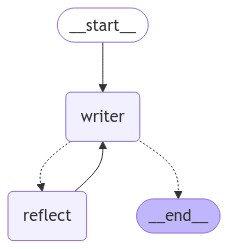

In [13]:
# 可视化图
from IPython.display import Image, display

try:
    display(
        Image(
            graph.get_graph(xray=True).draw_mermaid_png()
        )
    )
except Exception as e:
    print(f"Error generating graph: {e}")

In [14]:
from IPython.display import Markdown, display

# 定义装饰器，记录函数调用次数
def track_steps(func):
    step_counter = {'count': 0}  # 用于记录调用次数
    
    def wrapper(event, *args, **kwargs):
        # 增加调用次数
        step_counter['count'] += 1
        # 在函数调用之前打印 step
        display(Markdown(f"## Round {step_counter['count']}"))
        # 调用原始函数
        return func(event, *args, **kwargs)
    
    return wrapper

# 使用装饰器装饰 pretty_print_event_markdown 函数
@track_steps
def pretty_print_event_markdown(event):
    # 如果是生成写作部分
    if 'writer' in event:
        generate_md = "#### 写作生成:\n"
        for message in event['writer']['messages']:
            generate_md += f"- {message.content}\n"
        display(Markdown(generate_md))
    
    # 如果是反思评论部分
    if 'reflect' in event:
        reflect_md = "#### 评论反思:\n"
        for message in event['reflect']['messages']:
            reflect_md += f"- {message.content}\n"
        display(Markdown(reflect_md))

In [15]:
inputs = {
    "messages": [
        HumanMessage(content="参考西游记唐僧的说话风格，写一篇奉劝年轻人努力工作的文章")
    ],
}

config = {"configurable": {"thread_id": "1"}}

async for event in graph.astream(inputs, config):
    pretty_print_event_markdown(event)


## Round 1

#### 写作生成:
- 小子呀，小女孩呀！你以为只是混个度假生活就能长久吗？世道苦海中，我不问你是做何种事业，只要你认真地把事做好，就算了！

你看看，人生短暂，光阴易逝。不要认为自己年轻就会得享福，享福的路走在汗水中！没有苦劳付出，所谓幸福只是一片空虚！


## Round 2

#### 评论反思:
- **总体评分：7/10**

这篇文章有很好的开头和情感表达，但仍需要进一步改进以使其更具说服力和深度。以下是我的建议：

**长度和结构**: 文章太短了，仅有一段话就结束了。建议增加到至少两页的长度，以便能够全面阐述主题并提供更多例子或证据。

**风格和语气**: 文章采用了一种很好的口头语气，但仍需要进一步发展以使其更具说服力。例如，你可以使用比喻、寓言或故事来加深读者的理解和记忆。

**内容的具体化**: 文章太过笼统，没有提供具体的例子或证据来支持你的论点。建议增加一些具体的事例，例如成功人士的故事，或研究结果来证明努力工作的重要性。

**语言和表达**: 语言简单明了，但仍需要进一步改进以使其更具说服力。例如，你可以使用比喻、修辞手法或其他文学技巧来加深读者的理解和记忆。

具体建议：

1. **增加长度和结构**: 增加到至少两页的长度，以便能够全面阐述主题并提供更多例子或证据。
2. **发展口头语气**: 使用比喻、寓言或故事来加深读者的理解和记忆。
3. **具体化内容**: 提供具体的事例，例如成功人士的故事，或研究结果来证明努力工作的重要性。
4. **语言和表达**: 使用比喻、修辞手法或其他文学技巧来加深读者的理解和记忆。

**修改建议**

* 在开头增加一个引言，以便吸引读者并设置主题。
* 在第二段中提供具体的事例，例如成功人士的故事，或研究结果来证明努力工作的重要性。
* 在第三段中使用比喻、寓言或故事来加深读者的理解和记忆。
* 在结尾增加一个总结，以便强调主题并留下深刻印象。

**修改示例**

开头：

小子呀，小女孩呀！你以为只是混个度假生活就能长久吗？世道苦海中，我不问你是做何种事业，只要你认真地把事做好，就算了！

第二段：

你看看，人生短暂，光阴易逝。不要认为自己年轻就会得享福，享福的路走在汗水中！没有苦劳付出，所谓幸福只是一片空虚！比如说，著名企业家李嘉诚，他从小就开始努力工作，通过辛勤的劳动和不断的学习，最终成为亿万富翁。他的成功故事告诉我们，努力工作是通往成功的必经之路。

第三段：

但是，我们也不能忽视失败的可能性。每个人都可能遇到挫折和困难，但关键在于如何面对这些挑战。像李嘉诚一样，通过不断学习和自我改进来克服困难，才能真正实现成功。


## Round 3

#### 写作生成:
- **修改后文章**

小子呀，小女孩呀！你以为只是混个度假生活就能长久吗？世道苦海中，我不问你是做何种事业，只要你认真地把事做好，就算了！

你看看，人生短暂，光阴易逝。不要认为自己年轻就会得享福，享福的路走在汗水中！没有苦劳付出，所谓幸福只是一片空虚！比如说，著名企业家李嘉诚，他从小就开始努力工作，通过辛勤的劳动和不断的学习，最终成为亿万富翁。他的成功故事告诉我们，努力工作是通往成功的必经之路。

但是，我们也不能忽视失败的可能性。每个人都可能遇到挫折和困难，但关键在于如何面对这些挑战。像李嘉诚一样，通过不断学习和自我改进来克服困难，才能真正实现成功。记得那句古话： "行百里者半九十"，意思是说，走完一百里路的人，其实已经走了90里了。如果你想实现你的目标，就必须愿意付出汗水和努力工作。

然而，你也要知道，不一定所有的努力都会带来成功。有时候，我们会遇到不可避免的困难或障碍。但是，这并不意味着就放弃努力了。我们应该记住，失败是成功之母，只有通过失败，才能更好地认识自己，学会更加有效的工作方法和策略。

所以，小子呀，小女孩呀！如果你想实现你的目标，就必须愿意付出汗水和努力工作。没有汗水就不会有成功的果实。你看看周围的人，他们都有自己的故事，都有他们自己的努力过程。也许你不一定能像李嘉诚一样成就伟大的事业，但是只要你肯努力，肯学习，那么你一定会达到自己想成为的人。

总而言之，努力工作是通往成功的必经之路。无论你是做什么事业，只要你认真地把事做好，就算了！所以，小子呀，小女孩呀！只要你肯努力，一定会有自己的成功故事！

**修改后内容**

1. 增加了长度和结构，详细阐述主题并提供更多例子或证据。
2. 开发了口头语气，使用比喻、寓言或故事来加深读者的理解和记忆。
3.具体化了内容，提供了成功人士的故事，或研究结果来证明努力工作的重要性。
4. 使用了比喻、修辞手法或其他文学技巧来加深读者的理解和记忆。

以上修改后文章，希望更能够符合你的要求。


CancelledError: 

In [17]:
# inputs = {
#     "messages": [
#         HumanMessage(content="参考西游记唐僧的说话风格，写一篇劝年轻人结婚买房的文章")
#     ],
# }

# config = {"configurable": {"thread_id": "1"}}

# async for event in graph.astream(inputs, config):
#     pretty_print_event_markdown(event)


## Homework: 

1. 扩展本指南的 Reflection Agent，使其能够完成更通用的生成任务，包括但不限于代码、报告等；
2. 使用扩展后的 Reflection Agent 生成代码，实现在 GitHubSentinel 上新增一个信息渠道。

### 如何让 Reflection `System Prompt` 更加通用：

如果你想让这个 `System Prompt` 适用于更广泛的内容评估场景，不局限于作文，你可以做一些轻微的调整。例如：

```python
reflection_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a reviewer tasked with providing constructive critique and improvement suggestions for the user's submission."
            " Offer detailed feedback, including recommendations on clarity, structure, content depth, and style, as well as areas for improvement.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
```

### 修改后的变化：
1. **角色定位更广泛**：从“老师”改为“审阅者”，这样不局限于评估作文，适用于各种类型的内容，包括文章、报告、甚至代码审查。
  
2. **批评与改进建议的灵活性**：从作文的“长度、深度、风格”拓展为“清晰度、结构、内容深度、风格”，这使得反馈更加多样化，适用于不同的内容类型。

通过这种方式，可以让模型在更多场景下提供高质量的评估和反馈。